# Maximum Likelihood Amplitude Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from algorithms import amplitude_estimators, EstimationProblem
from algorithms import MaximumLikelihoodAmplitudeEstimation as MLAE
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import plot_histogram

In [2]:
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

## Define the estimation problem 
Qiskit's amplitude estimators have the same interface, so the same definition of the estimation problem can be reused.

https://qiskit.org/documentation/stubs/qiskit.algorithms.EstimationProblem.html#qiskit.algorithms.EstimationProblem

In [3]:
# Define the operator A. For the counting problem, this is the H gate applied on each qubit. 
def A(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)

    operator = qc.to_gate()
    operator.name = "A"
    return operator

## S_chi
# Flip the sign of the marked items
def S_chi(N, marked):
    S_chi_array = []
    for i in range(N):
        row = np.zeros(N)
        if (i in marked):
            row[i] = -1
        else:
            row[i] = 1
        S_chi_array.append(row)
    return Operator(S_chi_array)

## S_0
# Flip the sign of the 0 state
array_op = []
for i in range(N):
    row = np.zeros(N)
    if (i == 0):
        row[i] = -1
    else:
        row[i] = 1
    array_op.append(row)

S_0 = Operator(array_op)

# Define the operator Q.
def Q(nqubits, marked):
    qc = QuantumCircuit(nqubits)
    qc.append(S_chi(2**nqubits, marked), range(nqubits))
    qc.append(A(nqubits), range(nqubits))
    qc.append(S_0,        range(nqubits))
    qc.append(A(nqubits), range(nqubits))

    operator = qc.to_gate()
    operator.name = "Q"
    return operator

In [4]:
# Define the estimation problem
# https://qiskit.org/documentation/stubs/qiskit.algorithms.EstimationProblem.html#qiskit.algorithms.EstimationProblem
def good_state(state):
    bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
    return (state in bin_marked)

problem = EstimationProblem(
    state_preparation=A(n),  # A operator
    grover_operator=Q(n, marked),  # Q operator
    objective_qubits=range(n),
    is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [5]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

In [7]:
n_trials = 100
max_depth_log2 = 3
queries = np.zeros((max_depth_log2-1, n_trials))
errs = np.zeros((max_depth_log2-1, n_trials))

for i in range(2,max_depth_log2+1):
    for j in range(n_trials):
        mlae = MLAE(range(i), quantum_instance=aer_sim)
        result = mlae.estimate(problem)
        queries[i-2,j] = result.num_oracle_queries
        errs[i-2,j] = abs(k/N - result.estimation)

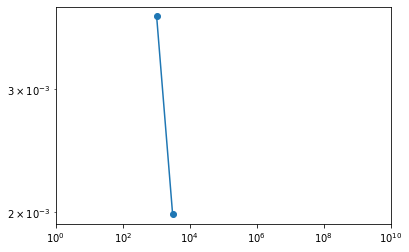

In [8]:
plt.scatter(queries.mean(axis=1), errs.mean(axis=1))
plt.plot(queries.mean(axis=1), errs.mean(axis=1))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1, 10**10)
plt.show()